In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pprint import pprint
from datetime import datetime
import dask_geopandas as dgpd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor, Pool, cv

from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials
import pickle
import warnings
from sklearn.metrics import r2_score


# Estimated Construction Costs for Housing

In [2]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [3]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [4]:
costs = dbi[dbi.estimated_cost.notna() | dbi.revised_cost.notna()]
costs = costs.copy()

In [5]:
costs['cost'] = costs.revised_cost
costs['cost'] = costs['cost'].fillna(costs.estimated_cost)

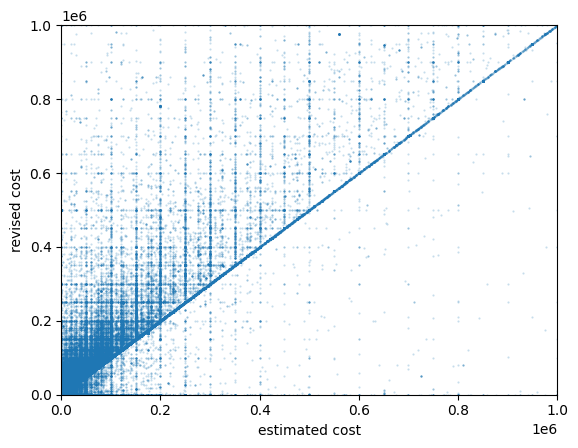

In [6]:
plt.scatter(dbi.estimated_cost, dbi.revised_cost, alpha=.25, s=.25)
plt.xlim((0, 1000000))
plt.ylim((0, 1000000))
plt.ylabel('revised cost')
plt.xlabel('estimated cost')
plt.show()

In [7]:
costs['new_units'] = costs['proposed_units'].fillna(0) - costs['existing_units'].fillna(0)

In [8]:
costs = costs.sort_values(['new_units'], ascending=False)

In [63]:
housing_costs = costs[costs.permit_number.isin(homes.BPA)]

In [64]:
housing_costs = housing_costs[housing_costs['completed_date'].notna()
                              & (housing_costs['new_units'] > 0)
                              & housing_costs['permit_type'].isin(('3','2','1'))]

In [65]:
housing_costs = housing_costs[housing_costs.permit_creation_date.dt.year > 2006]

In [66]:
housing_costs = housing_costs.sort_values('cost')

## Geospatial bluesky data

In [13]:
bluesky = gpd.read_feather('../geobluesky.geofeather')

In [14]:
bluesky = bluesky[bluesky['year'] >= 2007]

In [15]:
bluesky.year.max()

2016.0

In [16]:
bluesky.shape

(1530894, 19)

## Tax Data

In [48]:
tax = gpd.read_feather('../data/tax.geofeather')

In [18]:
tax.crs != bluesky.crs

True

In [19]:
tax.shape

(3086855, 43)

In [20]:
ddf = dgpd.from_geopandas(bluesky, npartitions=10)
ddf = ddf.to_crs(tax.crs)
bluesky = ddf.compute()

In [50]:
tax.closed_roll_year.min()

2007

In [51]:
df_list = []

for year in range(2007, 2017):
    parcels_year = bluesky[bluesky.year == year].copy()
    tax_year = tax[tax.closed_roll_year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, tax_year, how='left', predicate='contains'))
    

In [52]:
panel_data = pd.concat(df_list)

In [53]:
panel_data.shape

(1912071, 62)

I first do a geospatial match, but when a one to many relationship is identified, i give priority to non-geospatial matching

In [54]:
panel_data['non_geo_match'] = panel_data['MapBlkLot_Master'] == (panel_data.block + panel_data.lot)

panel_data = panel_data.sort_values('non_geo_match', ascending=False)

In [55]:
panel_data = panel_data.drop_duplicates(['MapBlkLot_Master', 'year'])

In [56]:
panel_data.shape

(1530894, 63)

In [57]:
panel_data = panel_data.drop(columns='index_right')

### Now to estimate housing costs given parcel and tax data

In [67]:
housing_costs = housing_costs[(housing_costs.cost / housing_costs.new_units) > 5000]

In [68]:
housing_costs_grouped = housing_costs.groupby(
    [
        'geometry', 
        'permit_creation_date'
    ]).agg({'cost': 'sum', 'new_units': 'sum'}).reset_index()

In [69]:
(housing_costs_grouped.cost / housing_costs_grouped.new_units).quantile(
    [0.01, 0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9]
)

0.01     10000.000000
0.05     20000.000000
0.10     35000.000000
0.20     60000.000000
0.30     83333.333333
0.40    113841.509434
0.50    172052.961538
0.60    276245.210728
0.70    351250.000000
0.80    437902.400000
0.90    560152.000000
dtype: float64

In [70]:
housing_costs = gpd.GeoDataFrame(housing_costs_grouped, crs=dbi.crs)

In [71]:
housing_costs = housing_costs.to_crs(panel_data.crs)

## Specify year

In [72]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel_data[panel_data.year == year].copy()
    housing_costs_year = housing_costs[housing_costs.permit_creation_date.dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, housing_costs_year, how='left', predicate='contains'))

In [73]:
panel_costs_df = pd.concat(df_list)

In [74]:
panel_costs_df.cost.notna().sum()

1609

In [75]:
panel_costs_df = panel_costs_df.drop(columns= ['MapBlkLot_Master', 'mapblklot', 'geometry',
                     'index_right', 'closed_roll_year', 'lot', 'block',
                     'current_sales_date', 'property_location', 
                     'parcel_number', 'non_geo_match', 'permit_creation_date'])

In [76]:
y = panel_costs_df['cost']

In [77]:
X = panel_costs_df.drop(columns=['cost', 'Zillow_Price_Real', 'Const_FedReserve_Real', 'new_units'])

In [78]:
X = X.replace({None: 'NaN', 'None': 'NaN', 'nan': 'NaN'})

In [79]:
trainX, testX, trainY = X.loc[y.notna()], X.loc[y.isna()], y[y.notna()]

In [80]:
trainY = np.log10(trainY)

### Catboost

In [82]:
cat_indices = np.where((trainX.dtypes == 'object') | (trainX.dtypes == 'category'))[0]

In [83]:
train_pool = Pool(data=trainX, label=trainY, cat_features=cat_indices)

In [84]:
class PenalizeNegativePredictions:
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            der1 = targets[index] - approxes[index]
            der2 = -1
            
            if approxes[index] < 0:
                der1 *= 1e3
                der2 *= 1e3
                
            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            
            result.append((der1, der2))
        
        return result

In [85]:
def hyperopt_objective(params):
    print(params)
    model = CatBoostRegressor(**params, random_seed=42)
    cv_data = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=False,
        logging_level='Silent',
        early_stopping_rounds=10
    )
    loss = cv_data['test-RMSE-mean'].min()
    return loss


# We initiate a Trial object to keep track of search results and we set a hyperparameter space
trials = Trials()
space = {
    "iterations": 1000,
    'learning_rate': hp.uniform('learning_rate', .02, .05),
    'depth': hp.randint('depth', 4, 10),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
    'border_count': hp.randint('border_count', 10, 255),
    'random_strength': hp.uniform('random_strength', 0, 2),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
    'loss_function': 'RMSE'
}

# We finally use fmin to perform the search
best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            rstate=np.random.default_rng(0),
            trials=trials)

{'boosting_type': 'Ordered', 'border_count': 214, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 0.04527328985963549, 'learning_rate': 0.02568000284464781, 'loss_function': 'RMSE', 'random_strength': 1.3645272414924494}
{'boosting_type': 'Ordered', 'border_count': 149, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 0.04405787173915748, 'learning_rate': 0.028272333452115262, 'loss_function': 'RMSE', 'random_strength': 1.6542316845138993}
{'boosting_type': 'Plain', 'border_count': 101, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 0.4070893747529913, 'learning_rate': 0.04108406392351036, 'loss_function': 'RMSE', 'random_strength': 0.884308534942049}
{'boosting_type': 'Ordered', 'border_count': 121, 'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 52.677039673917626, 'learning_rate': 0.029447028544400584, 'loss_function': 'RMSE', 'random_strength': 1.818652542365136}
{'boosting_type': 'Ordered', 'border_count': 190, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 0.2849842502848731, 'learni

In [86]:
best

{'boosting_type': 1,
 'border_count': 101,
 'depth': 7,
 'l2_leaf_reg': 0.4070893747529913,
 'learning_rate': 0.04108406392351036,
 'random_strength': 0.884308534942049}

In [87]:
best['boosting_type'] = 'Ordered' if best.get('boosting_type') == 0 else 'Plain'

In [88]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []

for train_index, test_index in kf.split(trainX):
    X_train_r, X_test_r = trainX.iloc[train_index], trainX.iloc[test_index]
    y_train_r, y_test_r = trainY.iloc[train_index], trainY.iloc[test_index]

    train_dataset_r = Pool(data=X_train_r, label=y_train_r,  cat_features=cat_indices)
    test_dataset_r = Pool(data=X_test_r, label=y_test_r,  cat_features=cat_indices)

    model_r = CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=0, verbose=1, **best)
    model_r.fit(train_dataset_r, verbose=0)

    predictions_r = model_r.predict(test_dataset_r)
    r2 = r2_score(y_test_r, predictions_r)
    r2_scores.append(r2)
r2_scores

[0.7194691753260527,
 0.7477038327036476,
 0.7092859738282575,
 0.6818755800643506,
 0.7585455269984476]

In [89]:
sum(r2_scores) / 5

0.7233760177841513

In [90]:
pickle.dump(trials, open("my_trials_construction.pkl", "wb"))

with open("my_trials_construction.pkl", "rb") as f:
    object = pickle.load(f)

df_trials = pd.DataFrame(object)
df_trials.to_csv(r'catboost_results_construction_costs.csv')

In [91]:
catboostFinal = CatBoostRegressor(**best, loss_function='RMSE', random_seed=0)

In [92]:
catboostFinal.fit(train_pool)

0:	learn: 0.8730617	total: 18.9ms	remaining: 18.9s
1:	learn: 0.8526186	total: 37.8ms	remaining: 18.9s
2:	learn: 0.8324013	total: 59.5ms	remaining: 19.8s
3:	learn: 0.8138785	total: 79.5ms	remaining: 19.8s
4:	learn: 0.7959671	total: 102ms	remaining: 20.2s
5:	learn: 0.7795051	total: 122ms	remaining: 20.2s
6:	learn: 0.7645879	total: 146ms	remaining: 20.7s
7:	learn: 0.7498868	total: 169ms	remaining: 21s
8:	learn: 0.7355311	total: 191ms	remaining: 21s
9:	learn: 0.7234561	total: 204ms	remaining: 20.2s
10:	learn: 0.7105951	total: 224ms	remaining: 20.1s
11:	learn: 0.6982491	total: 244ms	remaining: 20.1s
12:	learn: 0.6866217	total: 267ms	remaining: 20.2s
13:	learn: 0.6757780	total: 287ms	remaining: 20.2s
14:	learn: 0.6668567	total: 310ms	remaining: 20.4s
15:	learn: 0.6562793	total: 330ms	remaining: 20.3s
16:	learn: 0.6463330	total: 353ms	remaining: 20.4s
17:	learn: 0.6369017	total: 373ms	remaining: 20.3s
18:	learn: 0.6266337	total: 395ms	remaining: 20.4s
19:	learn: 0.6186198	total: 414ms	remaini

In [93]:
predictions = catboostFinal.predict(testX)

In [94]:
(predictions < 0).mean()

0.0

In [95]:
panel_data['construction_cost_est'] = 0
panel_data.loc[X.loc[y.isna()].index, 'construction_cost_est'] = 10 ** predictions
panel_data.loc[X.loc[y.notna()].index, 'construction_cost_est'] = 10 ** trainY

In [96]:
panel_data['construction_cost_est'].describe()

count    1.530894e+06
mean     8.958002e+05
std      4.915706e+06
min      6.000000e+03
25%      7.791463e+04
50%      1.336373e+05
75%      2.481898e+05
max      8.000000e+08
Name: construction_cost_est, dtype: float64

In [97]:
panel_costs_df['cost'].describe()

count    1.609000e+03
mean     6.565093e+06
std      2.796878e+07
min      6.000000e+03
25%      1.313100e+05
50%      4.984850e+05
75%      1.500000e+06
max      8.000000e+08
Name: cost, dtype: float64

In [98]:
panel_data.to_feather('../data/panel_data_estimated_costs.geofeather')

### ExtraTreesRegressor

In [108]:
X_dummy = pd.get_dummies(X, drop_first=True, dummy_na=True)

In [110]:
trainX_dummy, testX_dummy = X_dummy[y.notna()], X_dummy[y.isna()]

In [112]:
trainX_dummy = trainX_dummy.fillna(-9999)

In [115]:
regression = Pipeline([('rf',
                        ExtraTreesRegressor(n_estimators=100, random_state=0, 
                                            max_samples=1000, n_jobs=-1, bootstrap=True))])
rf_param_grid = [
    {
        'rf__max_depth': stats.randint(5, 35),
        'rf__ccp_alpha': stats.loguniform(1e-14, 1e-7),
        'rf__max_features': stats.uniform(.98, .02),
        'rf__max_samples': stats.randint(900, int(trainY.shape[0]*.8))
    }
]

In [116]:
rs = RandomizedSearchCV(regression, rf_param_grid, n_iter=10, random_state=0, verbose=1, cv=5)

rs.fit(trainX_dummy, trainY)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('rf',
                                              ExtraTreesRegressor(bootstrap=True,
                                                                  max_samples=1000,
                                                                  n_jobs=-1,
                                                                  random_state=0))]),
                   param_distributions=[{'rf__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000293A23174F0>,
                                         'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029304CC85E0>,
                                         'rf__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000029304CC4610>,
                                         'rf__max_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029304CC4970>}],
                   random_state=0, verbose=1)

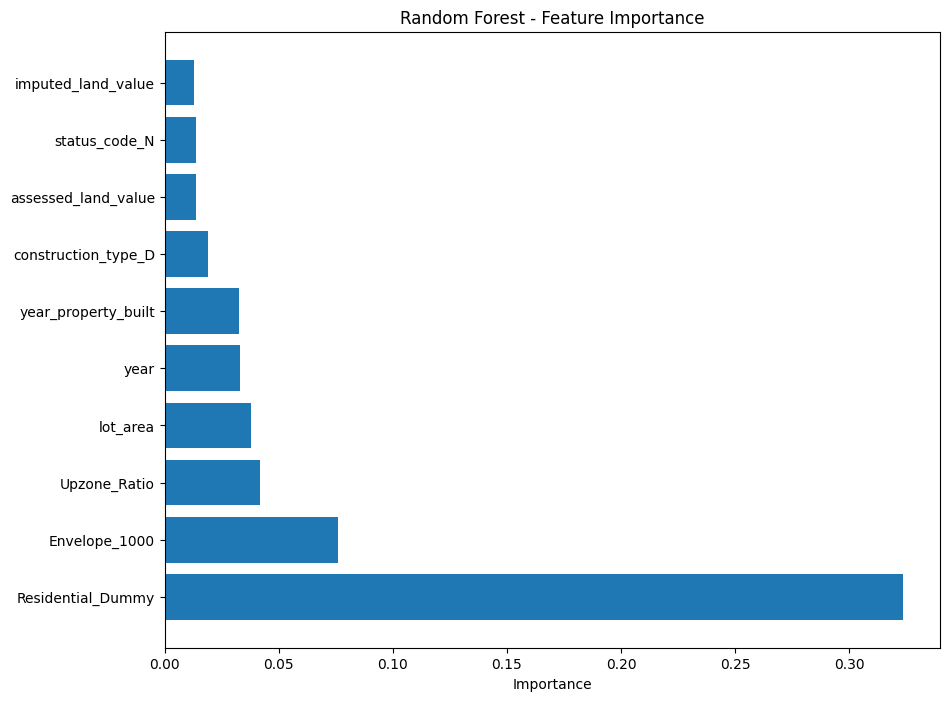

In [117]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:10]

    plt.figure(figsize=(10,8))
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'], align='center')
    plt.xlabel('Importance')
    plt.title(model_type + ' - Feature Importance')
    plt.show()

plot_feature_importance(rs.best_estimator_['rf'].feature_importances_, trainX_dummy.columns, 'Random Forest')

In [118]:
param_search_results = pd.DataFrame(rs.cv_results_['params'])
param_search_results['score'] = rs.cv_results_['mean_test_score']
param_search_results = param_search_results.sort_values('score', ascending=False)
param_search_results

,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__max_samples,score
8,1.186147e-10,30,0.998893,931,0.601422
9,5.512559e-14,28,0.985291,1270,0.598268
4,5.616860e-12,30,0.981421,1165,0.597276
7,1.699634e-11,24,0.993578,1188,0.595254
0,6.945356e-11,26,0.996885,1151,0.594060
5,3.445110e-10,21,0.996652,1235,0.593186
6,1.230510e-08,23,0.989472,1077,0.591679
2,1.156406e-11,11,0.981134,1214,0.586276
1,6.519020e-11,14,0.992471,1142,0.585709
3,2.206256e-11,12,0.990578,988,0.582744


In [134]:
predY = 10 ** rs.predict(testX_dummy)

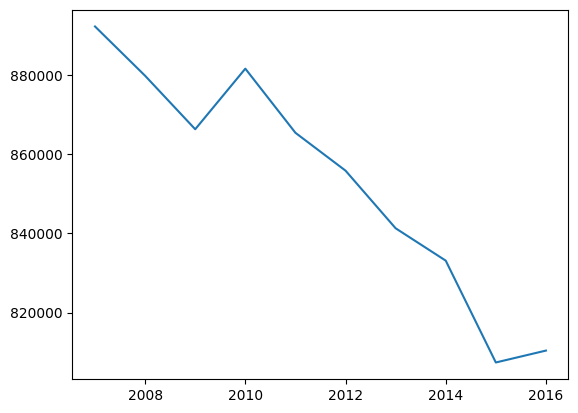

In [135]:
plt.plot(pd.DataFrame({'year': testX_dummy['year'], 'cost': predY}).groupby('year').agg({'cost': 'mean'}))

In [121]:
trainY.min()

3.7781512503836434

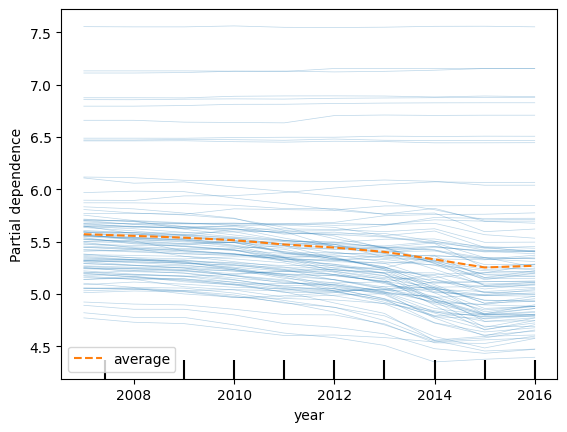

In [133]:
PartialDependenceDisplay.from_estimator(
    rs, 
    testX_dummy.sample(100, random_state=123), 
    ['year'], 
    kind='both')



In [128]:
known_construction = pd.read_csv('../data/efz/construction.csv', skiprows=1, sep=' ', on_bad_lines='skip')

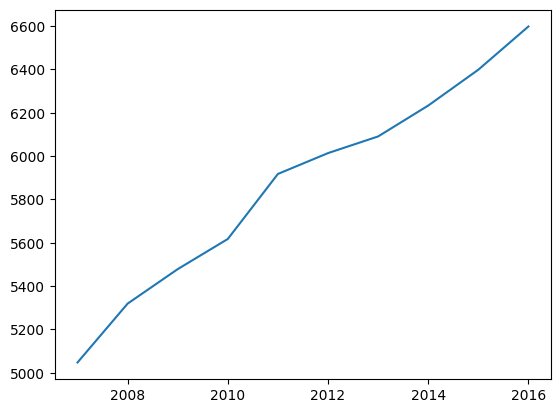

In [129]:
plt.plot(known_construction[(known_construction['YEAR'] > 2006) & 
                            (known_construction['YEAR'] < 2017)].groupby('YEAR')['BCI'].mean())